In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import glob
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall
from asreviewcontrib.insights.plot import _recall_values
from asreviewcontrib.insights.utils import pad_simulation_labels
import asreviewcontrib.insights.metrics as met
from langdetect import detect
import pylab

In [2]:
classifiers = ['logistic', 'svm']
state_files = "./{}_sims/output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_{}_{}_0.asreview"
csv_file = "./data/Hamilton_{}.csv"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'mbert', 'muse', 'mlongt5', 'labse', 'laser', 'mpnet', 'minilm', 'stsb']

In [3]:
language_dfs = {}
for dataset in datasets:
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

# Dataset descriptives

In [4]:
data_descriptives = pd.read_csv("./data/data_descriptives.csv")
data_descriptives.head()

,Unnamed: 0,n_records,n_relevant,n_irrelevant,n_unlabeled,n_missing_title,n_missing_abstract,n_duplicates
0,data_stats_Hamilton_English.json,1859,87,1772,0,5,305,9
1,data_stats_Hamilton_Multi_1.json,1859,87,1772,0,5,305,9
2,data_stats_Hamilton_Multi_2.json,1859,87,1772,0,5,305,9
3,data_stats_Hamilton_Original.json,1859,87,1772,0,5,305,9


## Metrics

In [6]:
metrics_df = pd.DataFrame()
for classifier in classifiers:
    for dataset in datasets:
        for model in models:
            row = {'Dataset':dataset, 'Classifier':classifier, 'Model':model}
            with open_state(state_files.format(classifier, dataset, dataset, classifier, model)) as state:
                metrics = met.get_metrics(state)
                for item in metrics['data']['items']:
                    if item.get('title') == 'Time to discovery':
                        for paper_td in item.get('value'):
                            if paper_td[0] in [300, 567, 741, 878, 1112]:
                                row['td_'+str(paper_td[0])] = paper_td[1]
                    elif type(item.get('value')) != list:
                        row[item.get('title')] = item.get('value')
                    else:
                        for value in item.get('value'):
                            row[str(item.get('title'))+'_'+str(value[0])] = value[1]
            metrics_df = metrics_df.append(row, ignore_index = True)
metrics_df

,Average time to discovery,Classifier,Dataset,Extra Relevant record Found_0.1,Model,Recall_0.1,Recall_0.25,Recall_0.5,Recall_0.75,Recall_0.9,Work Saved over Sampling_0.95,td_1112,td_300,td_567,td_741,td_878
0,145.127907,logistic,Original,0.651163,tfidf,0.755814,0.918605,1.000000,1.000000,1.0,0.647281,713.0,569.0,566.0,183.0,187.0
1,118.744186,logistic,Original,0.732558,sbert,0.837209,0.965116,0.988372,1.000000,1.0,0.813139,758.0,1138.0,117.0,74.0,56.0
2,222.279070,logistic,Original,0.488372,mbert,0.593023,0.895349,0.988372,1.000000,1.0,0.604200,318.0,417.0,283.0,292.0,309.0
3,158.779070,logistic,Original,0.569767,muse,0.674419,0.941860,1.000000,1.000000,1.0,0.704900,265.0,663.0,103.0,17.0,142.0
4,243.093023,logistic,Original,0.395349,mlongt5,0.500000,0.848837,1.000000,1.000000,1.0,0.611739,98.0,245.0,65.0,27.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,156.011628,svm,Multi_2,0.604651,labse,0.709302,0.930233,1.000000,1.000000,1.0,0.682822,629.0,598.0,36.0,7.0,25.0
76,241.209302,svm,Multi_2,0.453488,laser,0.558140,0.837209,0.988372,0.988372,1.0,0.613355,468.0,899.0,235.0,18.0,25.0
77,216.534884,svm,Multi_2,0.534884,mpnet,0.639535,0.883721,0.965116,0.988372,1.0,0.513732,565.0,1447.0,785.0,25.0,82.0
78,274.186047,svm,Multi_2,0.372093,minilm,0.476744,0.825581,0.941860,0.976744,1.0,0.488422,832.0,1394.0,1479.0,30.0,204.0


In [7]:
metrics_df.to_csv("metrics.csv")

## Plots

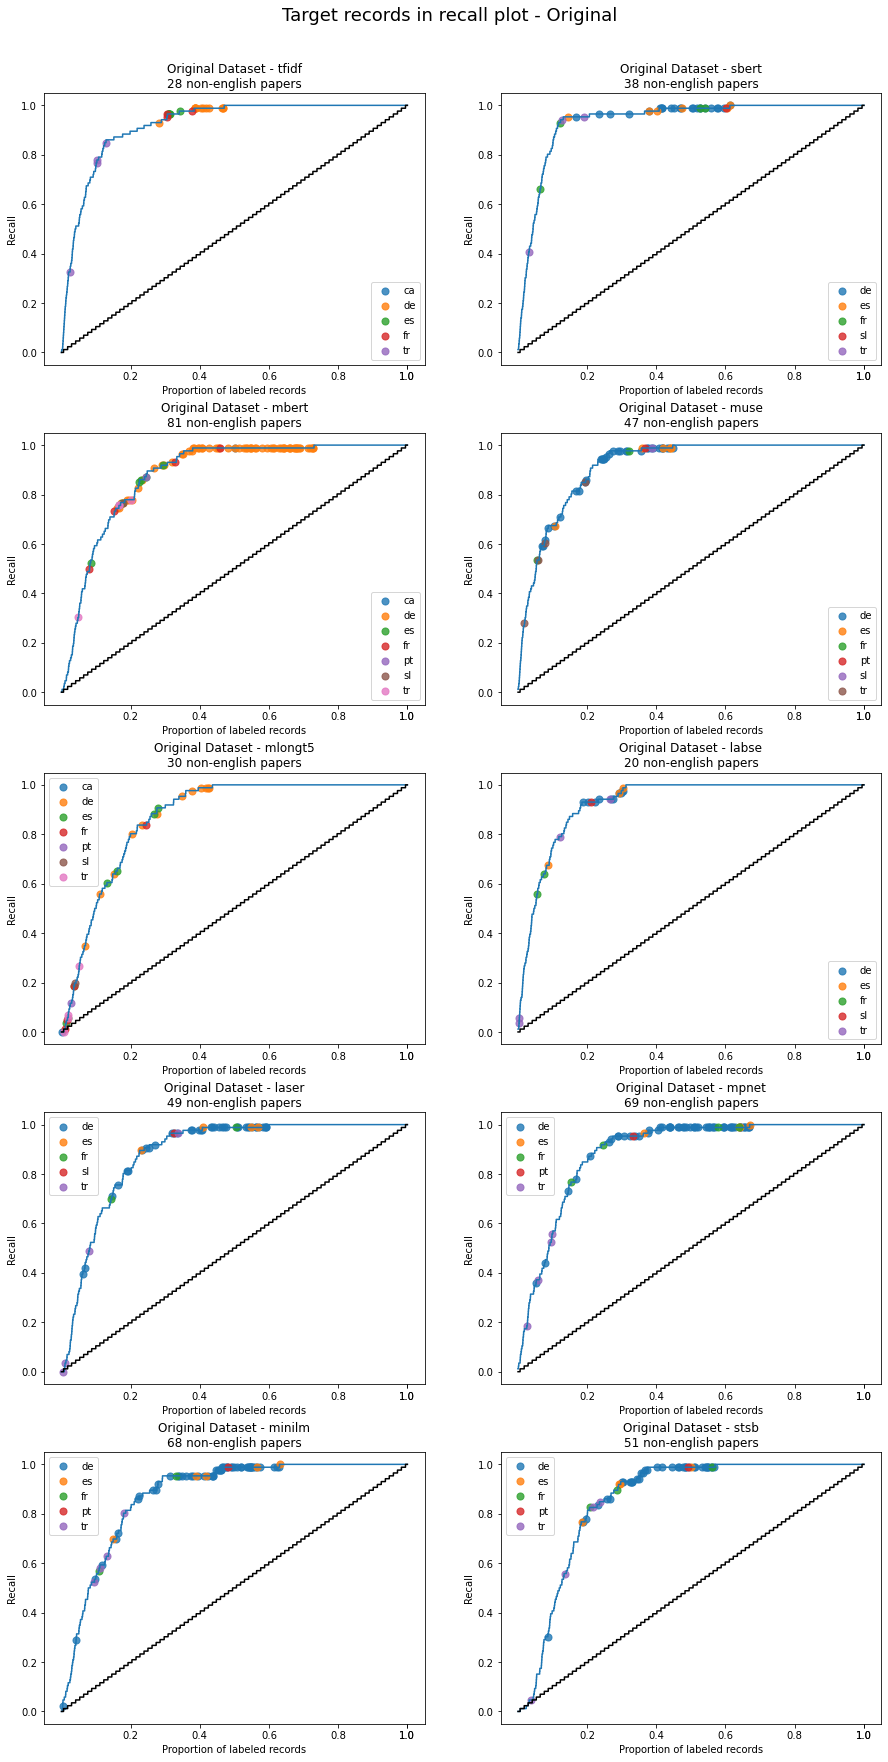

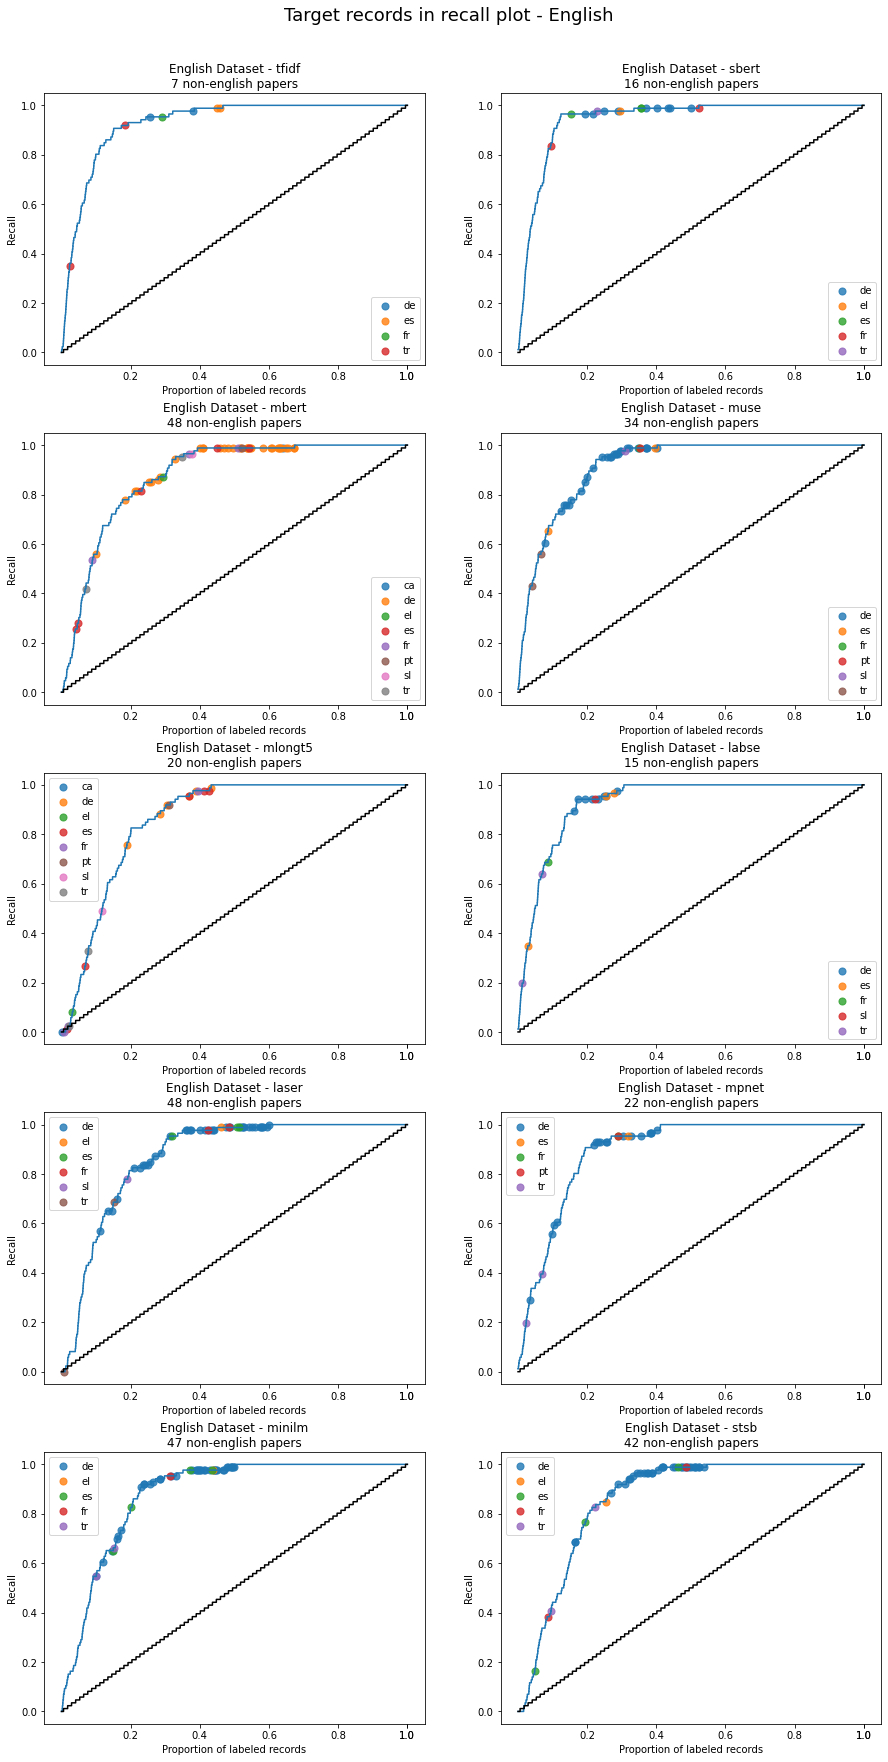

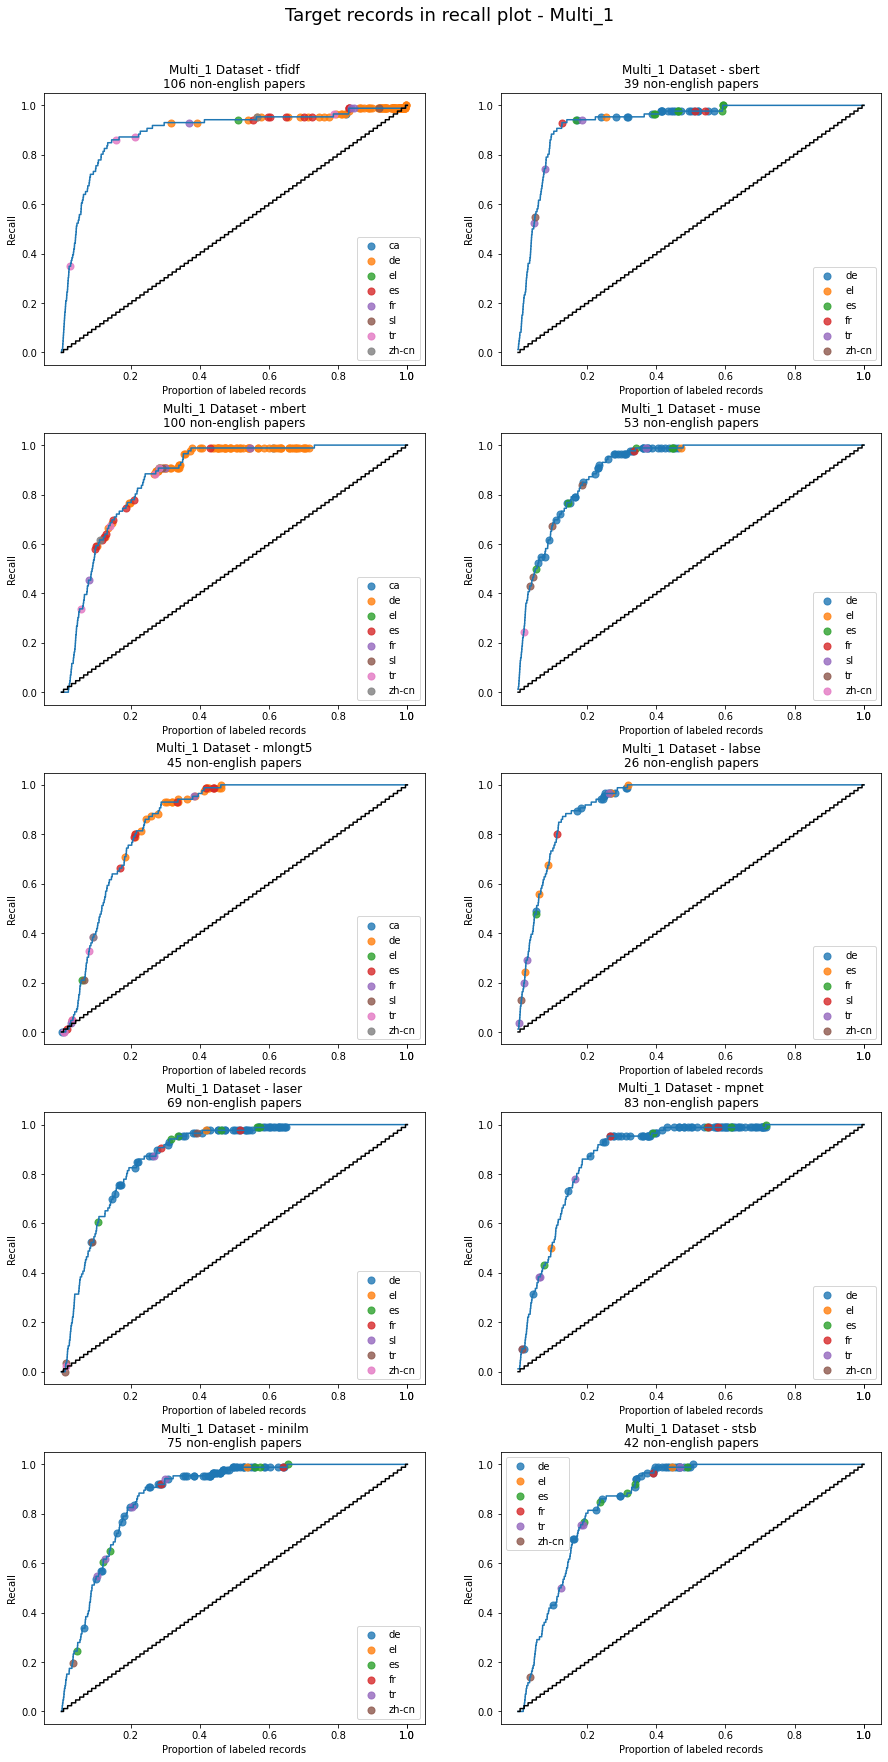

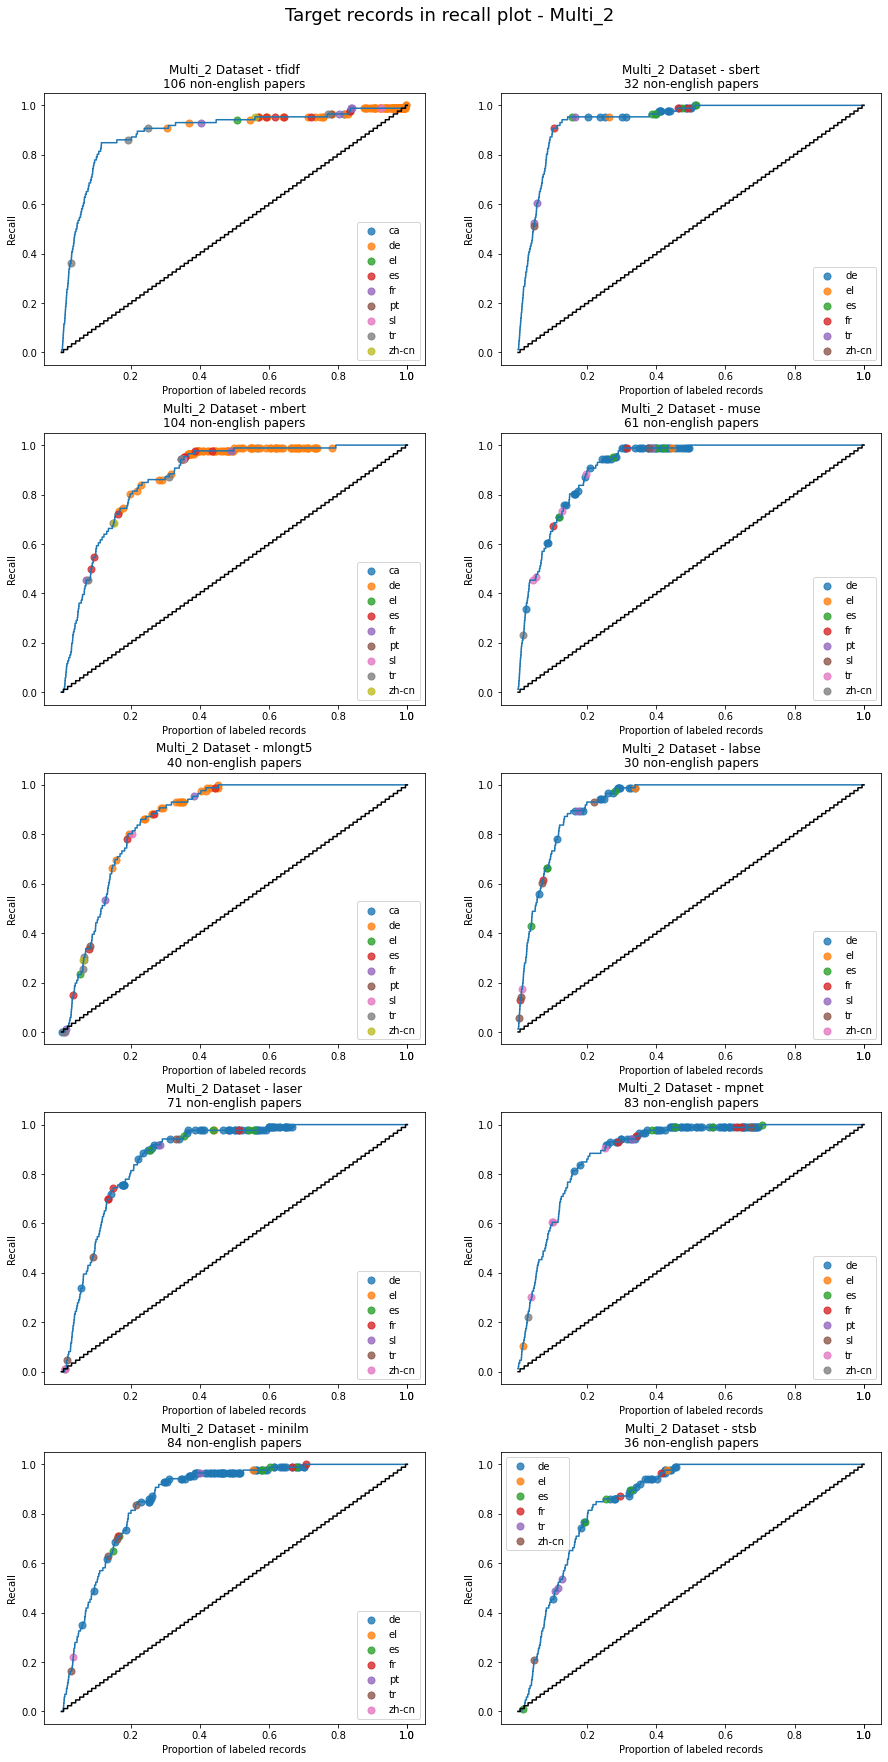

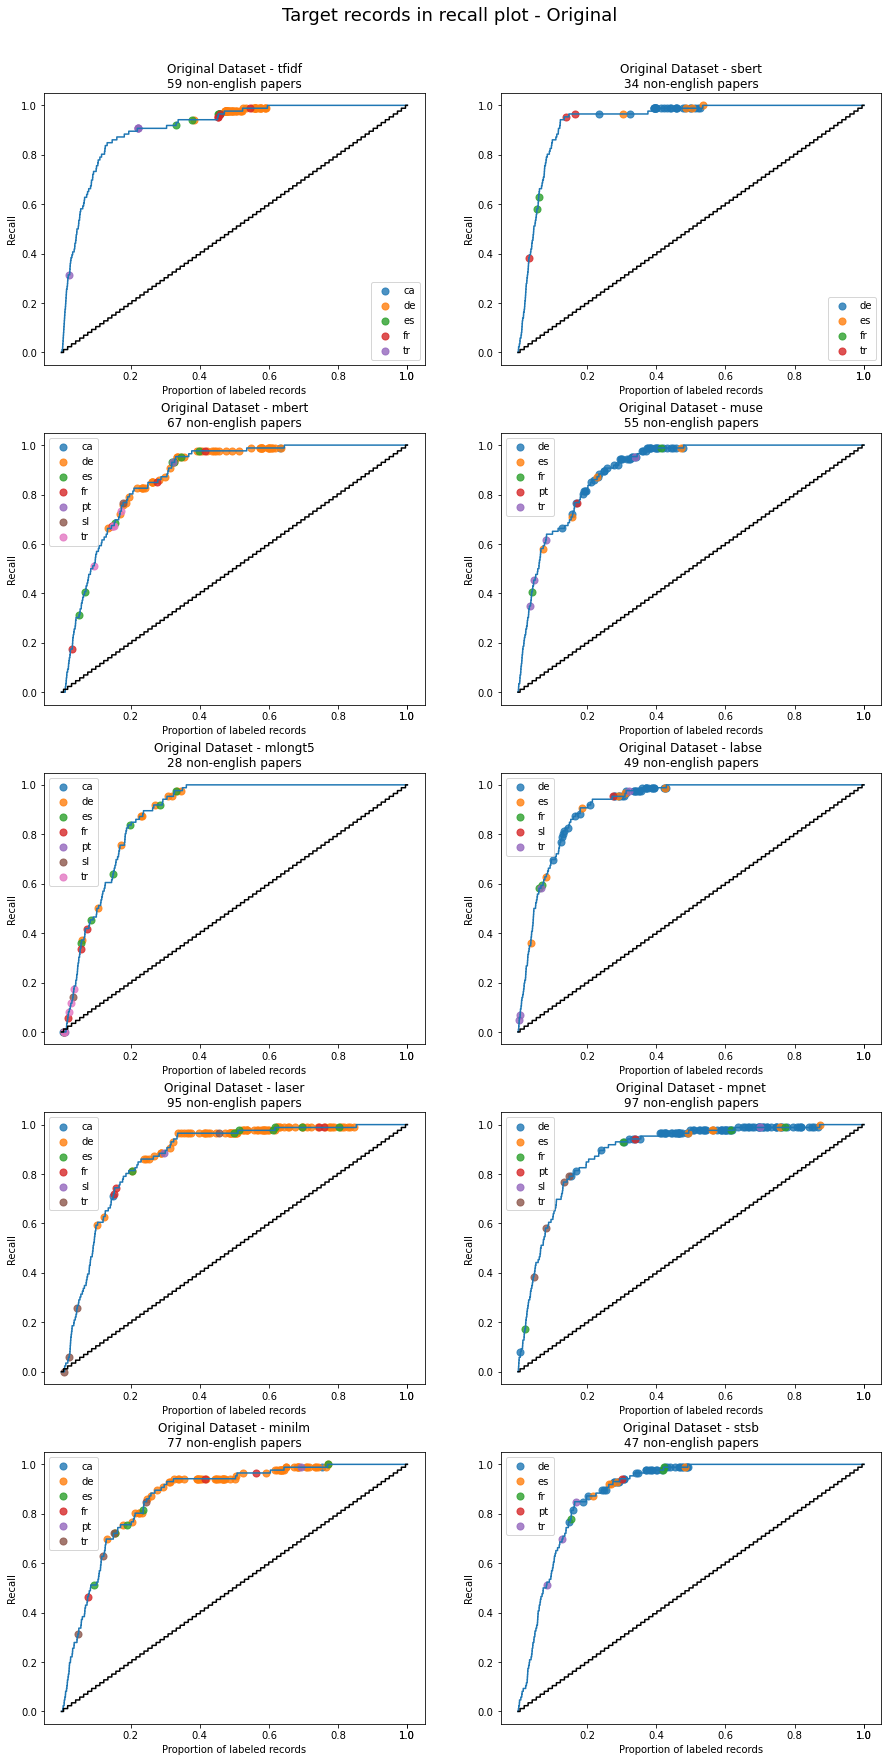

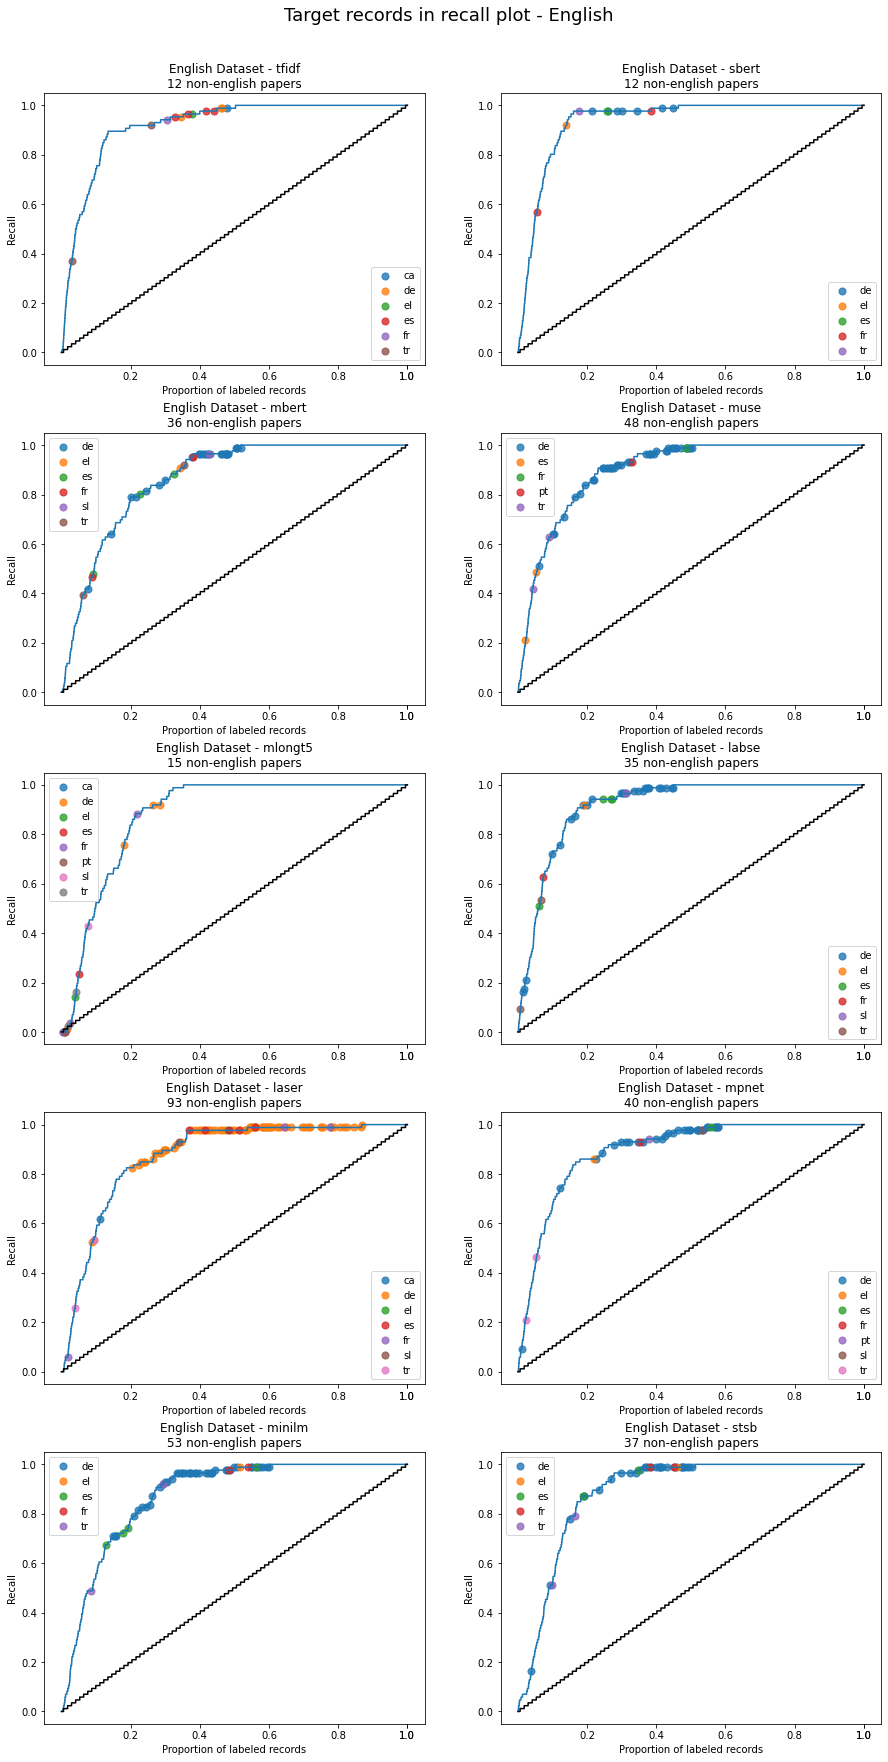

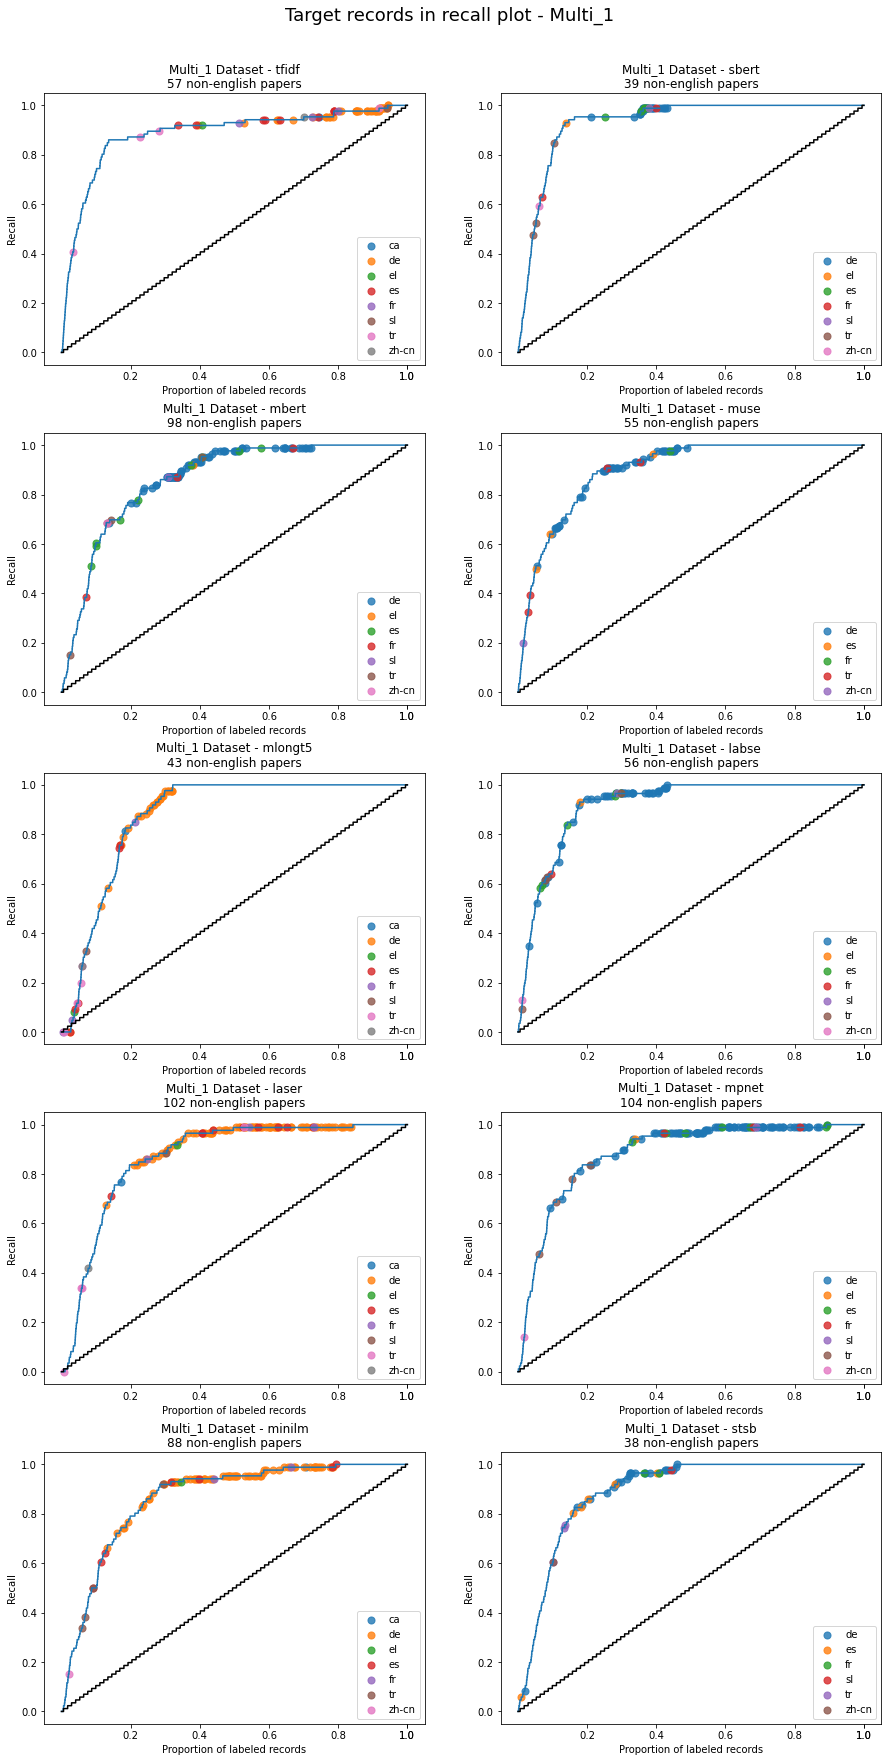

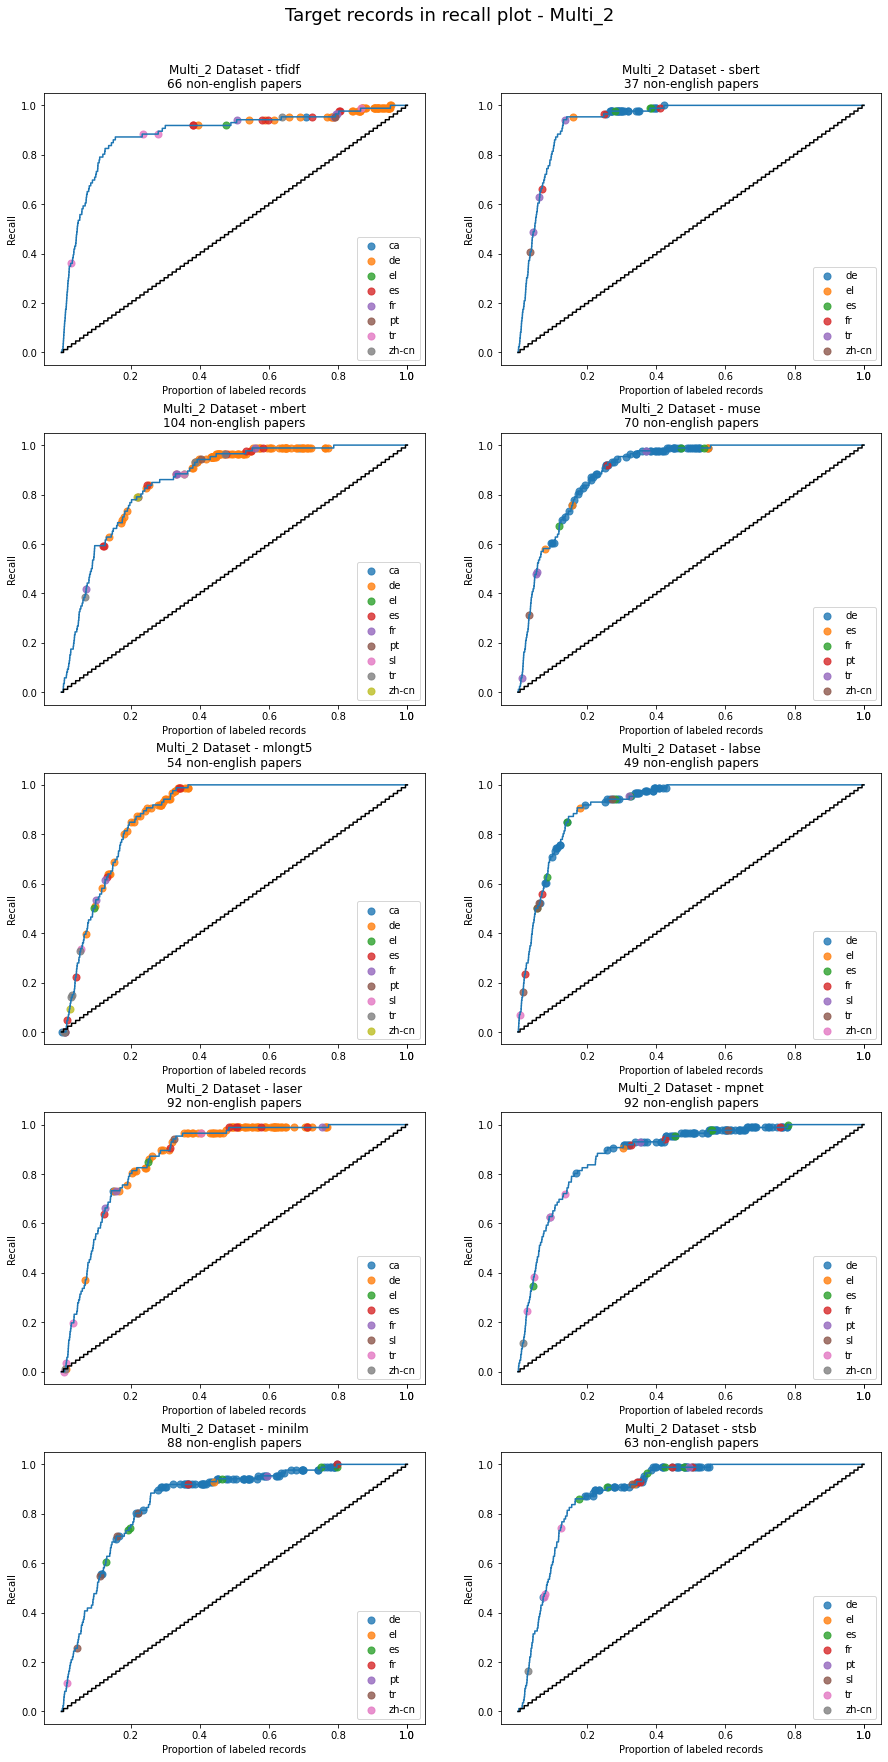

In [109]:
for classifier in classifiers:    
    for dataset in datasets:
        plt.figure(figsize=(15, 30))
        plt.subplots_adjust(hspace=0.25)
        plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.92)
        n=0
        for model in models:
            ax = plt.subplot(5, 2, n + 1)
            with open_state(state_files.format(classifier, dataset, dataset, classifier, model)) as state:
                states_df = state.get_dataset()

                sim_labels = pad_simulation_labels(state)
                x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)

                languages = language_dfs[dataset]
                states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
                non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False))]

                #print(non_english.language.head().sort_values().unique())

                for language in non_english.language.sort_values().unique():
                    temp = non_english.loc[non_english.language==language]
                    ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", alpha=0.8, s=50)
                ax.legend(non_english.language.sort_values().unique())

                #draw the plot
                plot_recall(ax, state)

                ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
                n+=1

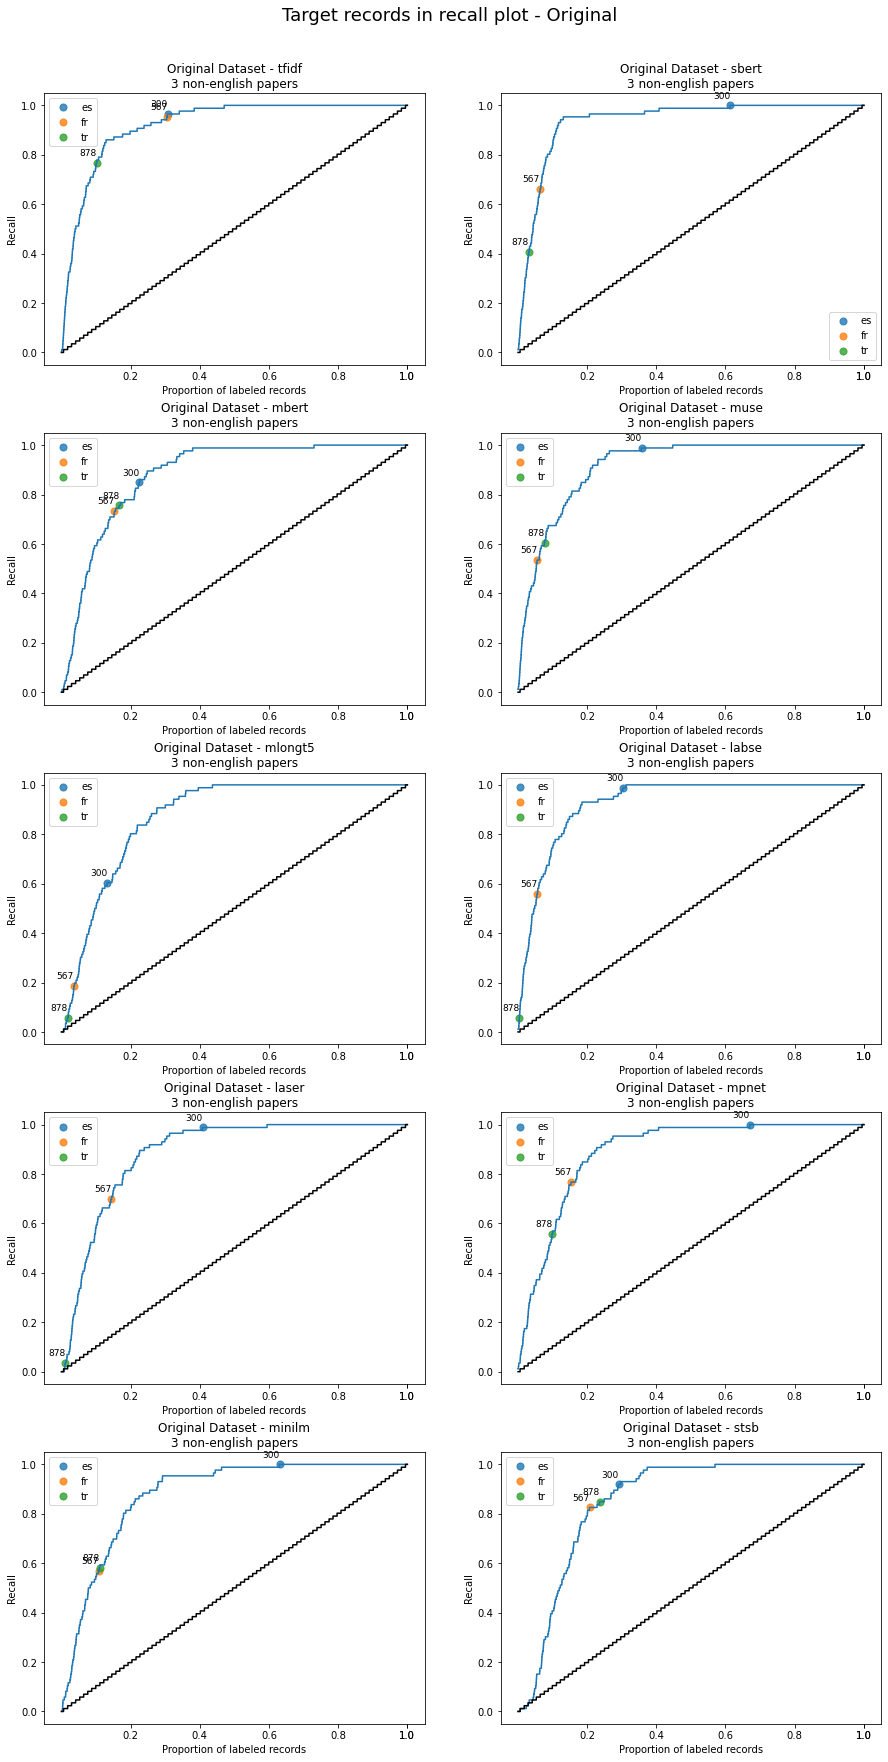

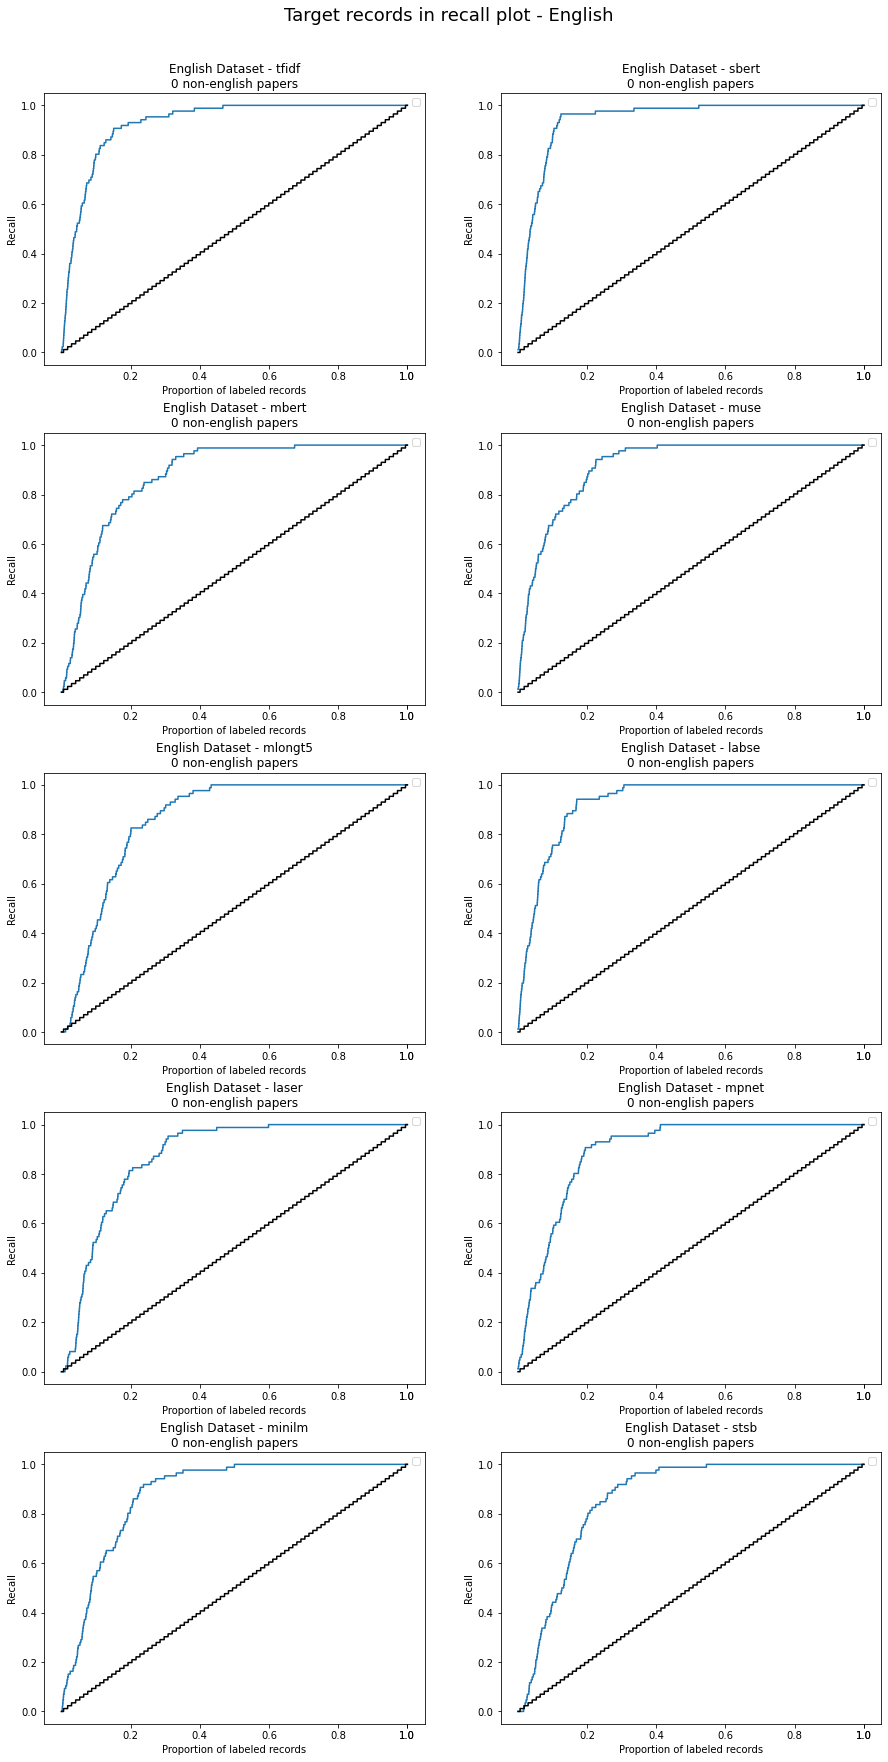

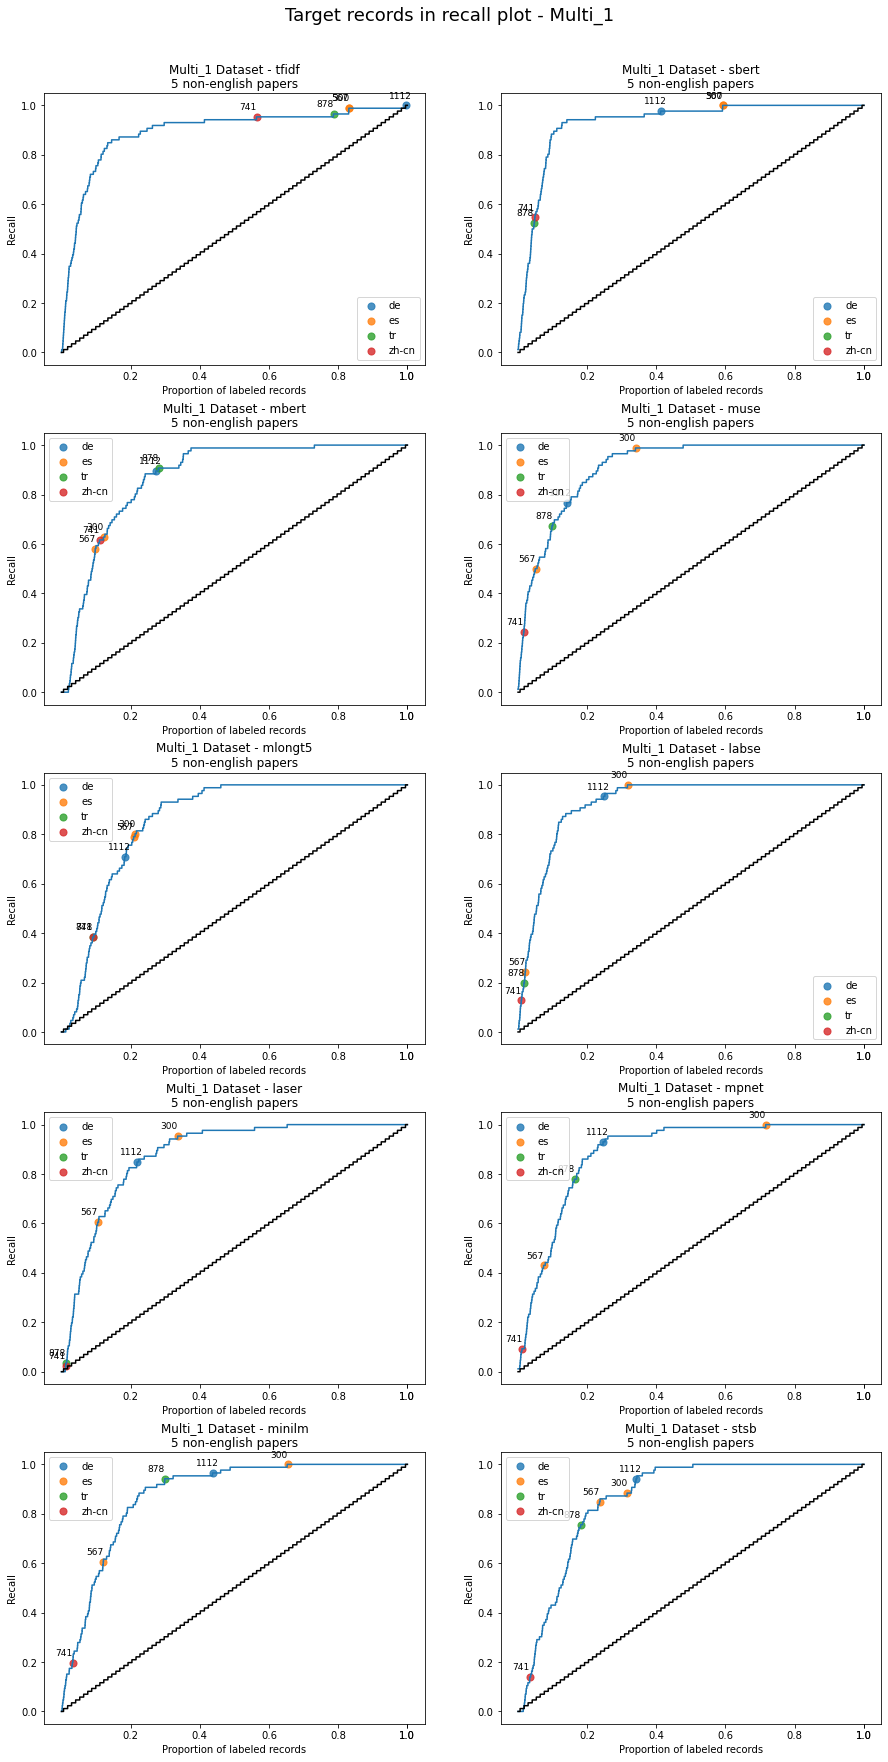

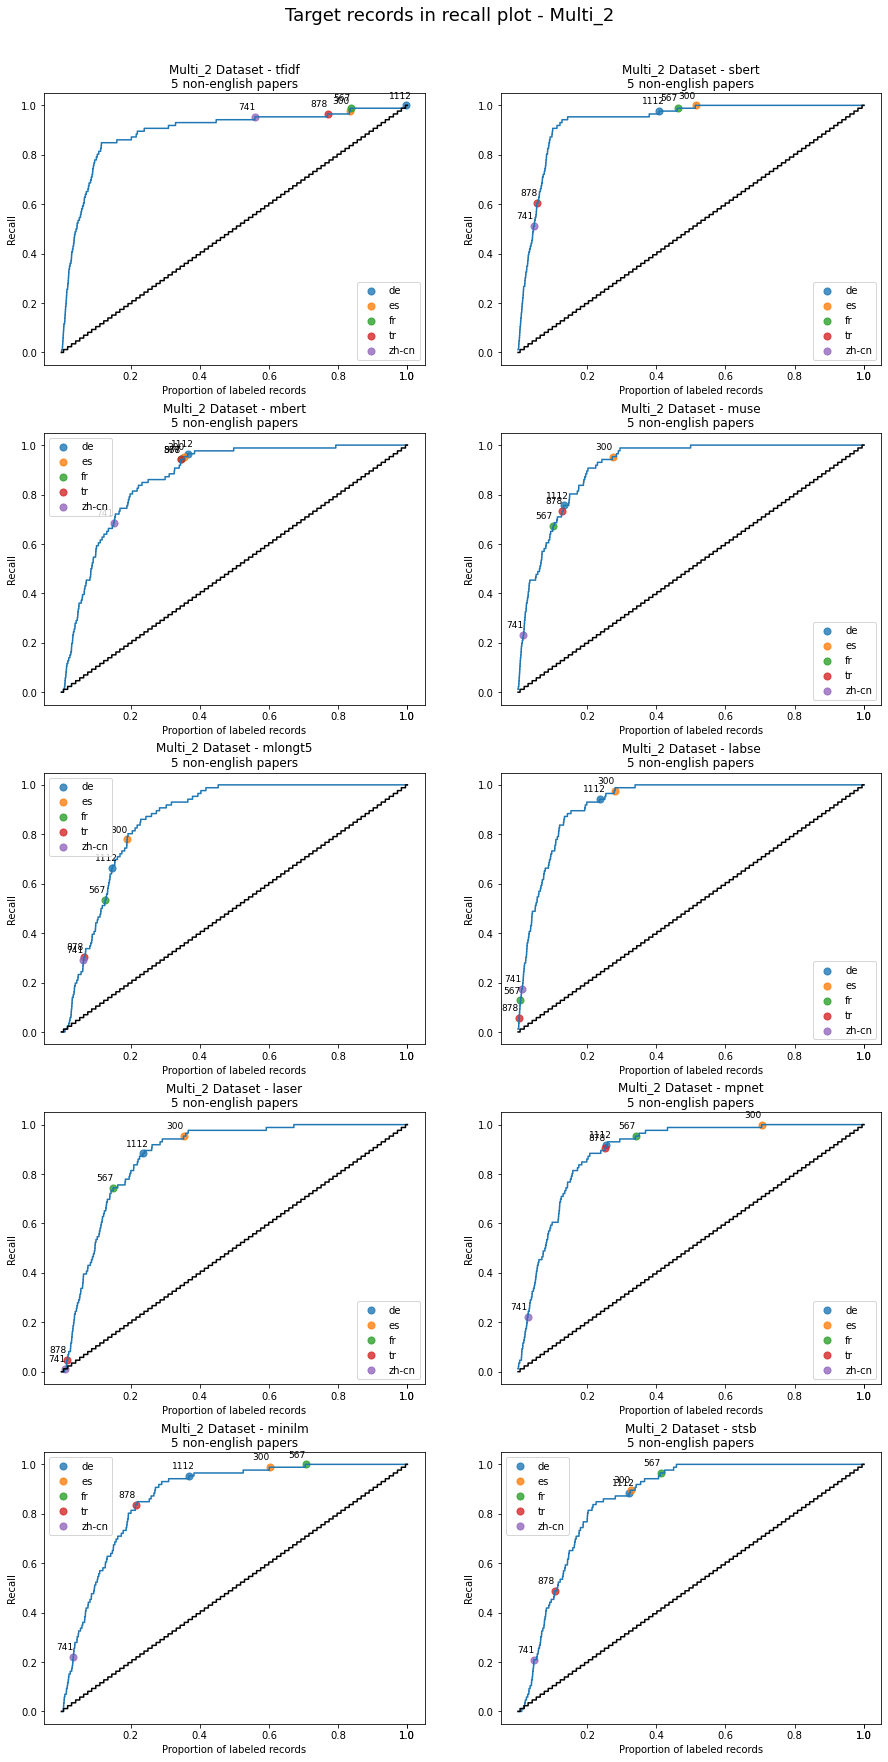

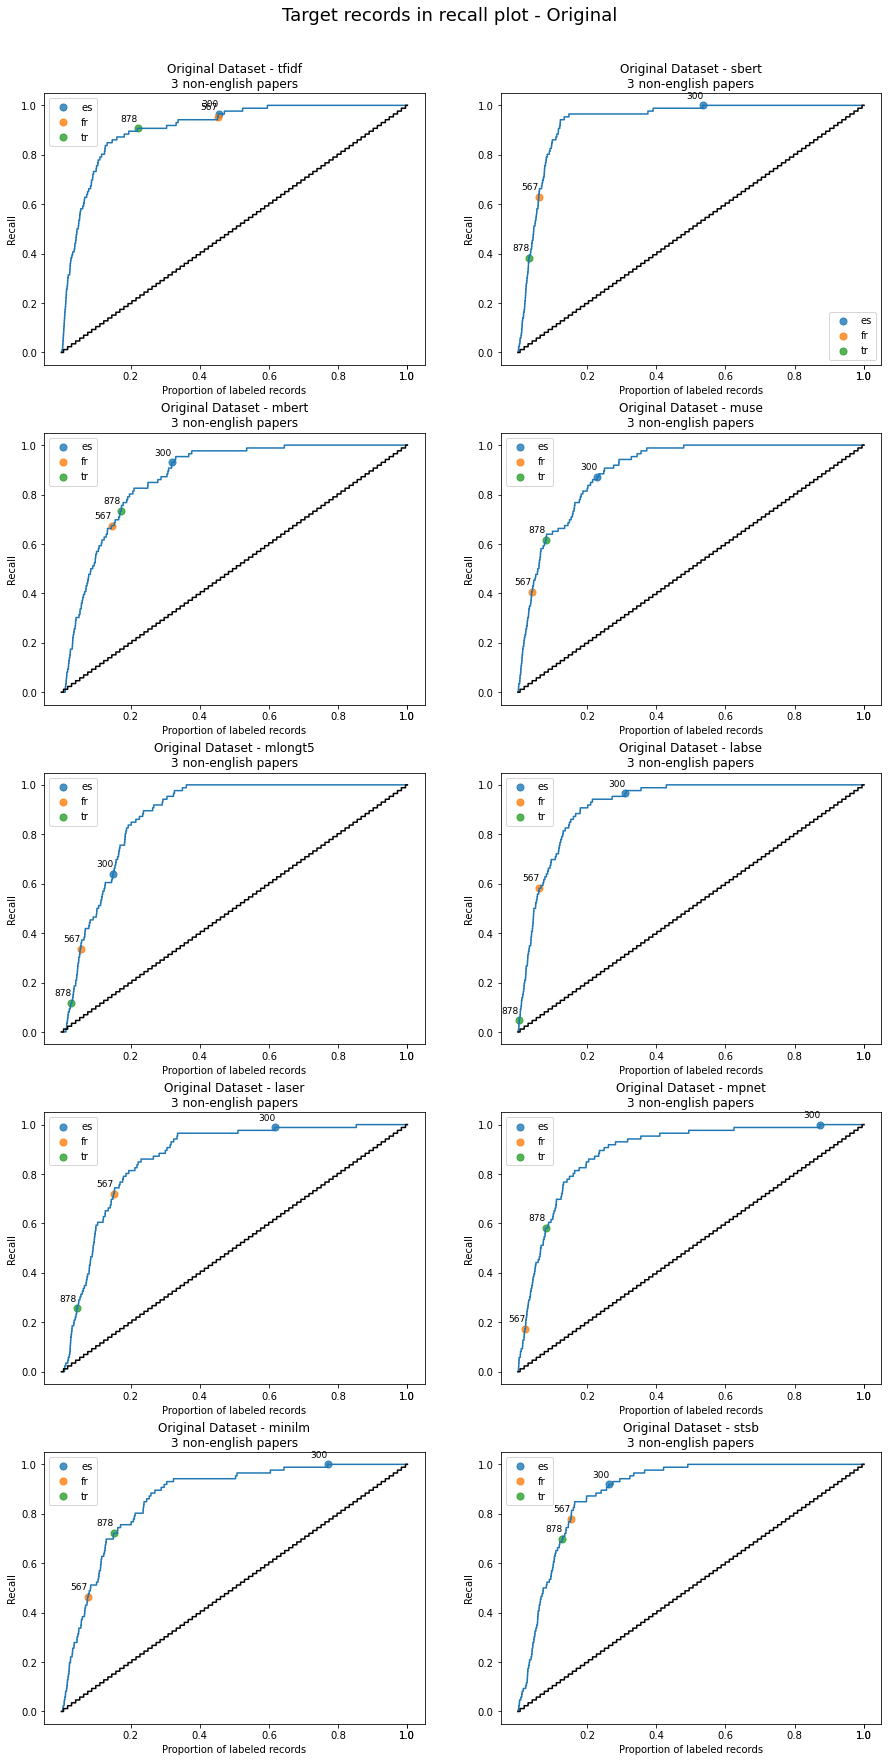

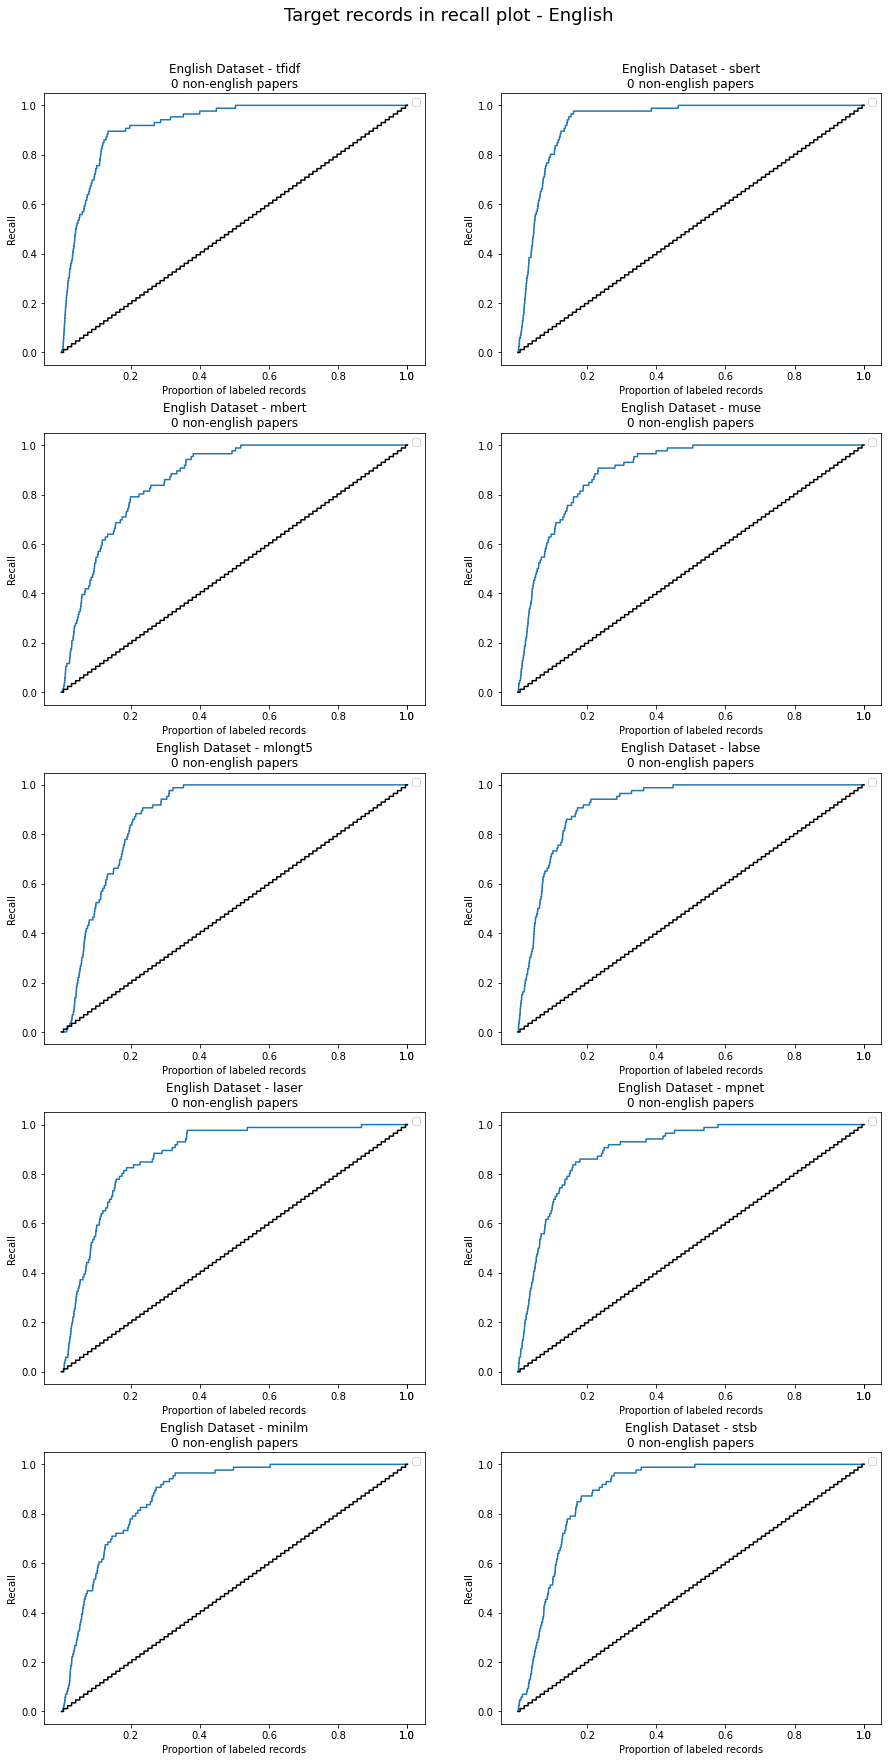

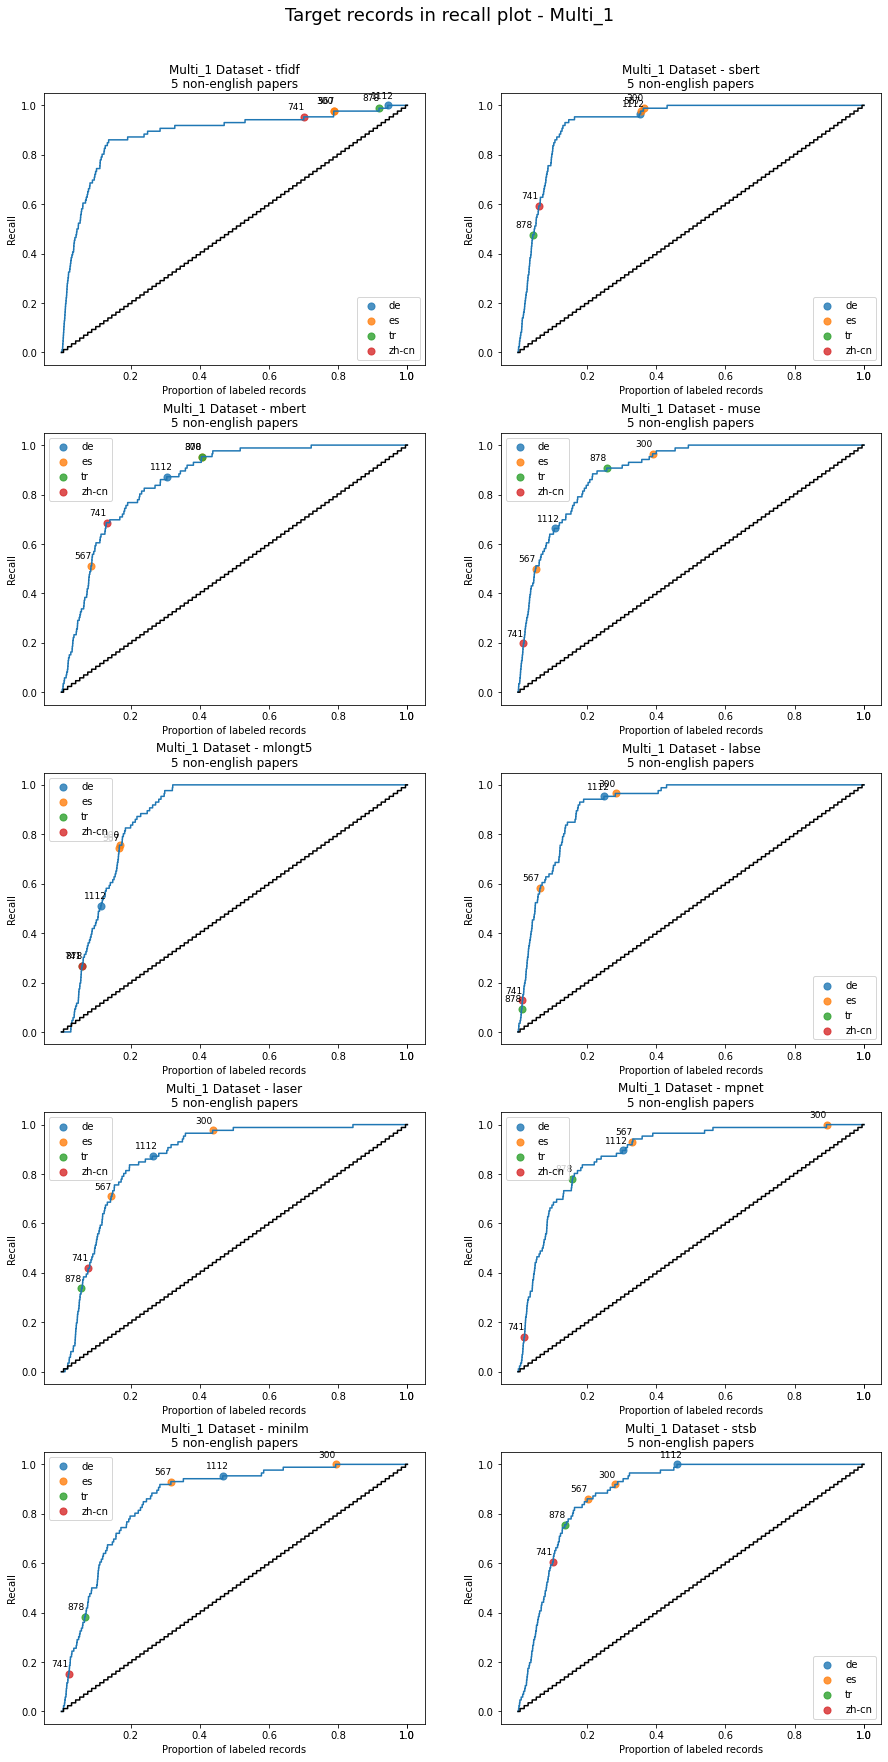

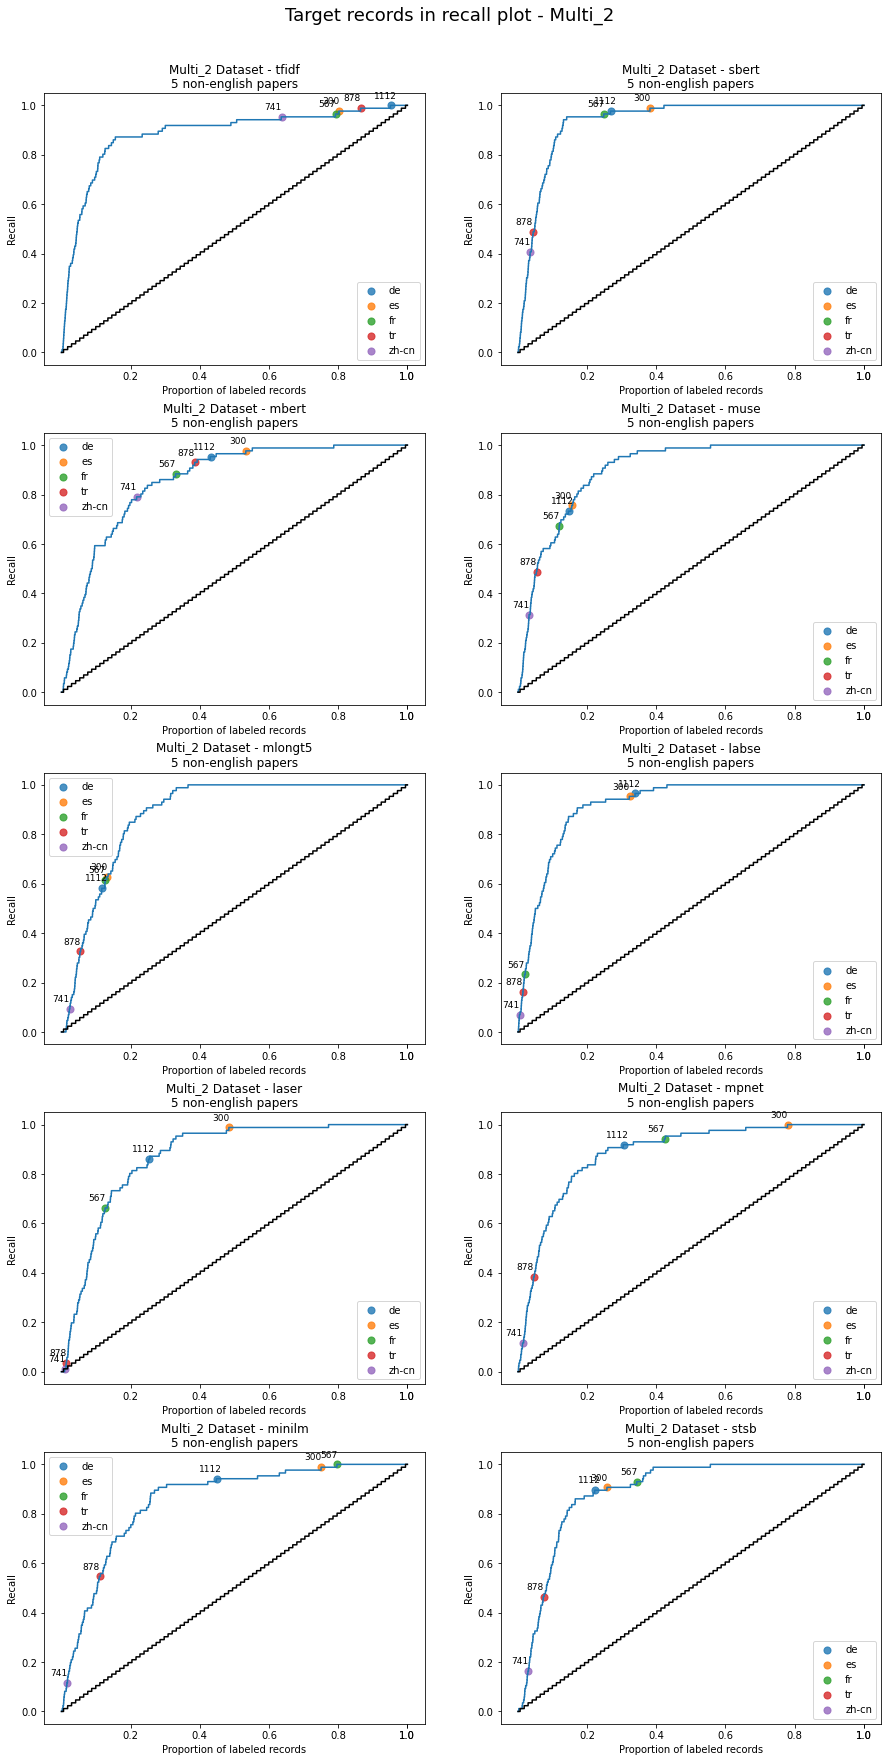

In [112]:
for classifier in classifiers:    
    for dataset in datasets:
        plt.figure(figsize=(15, 30))
        plt.subplots_adjust(hspace=0.25)
        plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.92)
        n=0
        for model in models:
            ax = plt.subplot(5, 2, n + 1)
            with open_state(state_files.format(classifier, dataset, dataset, classifier, model)) as state:
                states_df = state.get_dataset()

                sim_labels = pad_simulation_labels(state)
                x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)

                languages = language_dfs[dataset]
                states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
                non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                            & (states_df.label == 1))]

                for language in non_english.language.sort_values().unique():
                    temp = non_english.loc[non_english.language==language]
                    ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50, alpha=0.8)
                    for index, row in temp.iterrows():
                        ax.text(x[index]-0.05, y[index]+0.03, row.record_id, fontsize=9)
                ax.legend(non_english.language.sort_values().unique())

                #draw the plot
                plot_recall(ax, state)

                ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
                n+=1